In [1]:
%matplotlib inline
import wrf
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf

from poisson_solve import solve_2D_poisson_fd

In [2]:
def d_dx(var, dx):
    dvar_dx = np.zeros(var.shape)
    
    dvar_dx[:, 0] = (var[:, 1] - var[:, 0]) / dx     # FDM
    dvar_dx[:, -1] = (var[:, -1] - var[:, -2]) / dx  # BDM
    for i in range(1, var.shape[1]-1):
        dvar_dx[:,i] = (var[:,i+1] - var[:,i-1]) / (2 * dx)   # CDM
        
    return dvar_dx


def d_dy(var, dy):
    dvar_dy = np.zeros(var.shape)
    
    dvar_dy[0,:] = (var[1,:] - var[0,:]) / dy      # FDM
    dvar_dy[-1,:] = (var[-1,:] - var[-2,:]) / dy   # BDM
    for j in range(1, var.shape[0]-1):
        dvar_dy[j,:] = (var[j+1,:] - var[j-1,:]) / (2 * dy)   # CDM
    
    return dvar_dy


def stfunc_to_vorticity(psi, dx, dy):
    """
    stfunc = stream function
    
    Parameter:
    ---------
    psi: 2d-array, shape=(ny, nx)
        Stream Function.
    dx, dy: int or float
        The horizontal resolution.
    
    Return:
    ------
    Vorticity field.
    """
    ny, nx = psi.shape
    vorticity = np.zeros((ny, nx))
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            vorticity[j,i] = ( (psi[j,i+1] - 2*psi[j,i] + psi[j,i-1]) / dx**2   
                               + (psi[j+1,i] - 2*psi[j,i] + psi[j-1,i]) / dy**2 )
    vorticity[0,:] = vorticity[1,:]
    vorticity[-1,:] = vorticity[-2,:]
    vorticity[:,0] = vorticity[:,1]
    vorticity[:,-1] = vorticity[:,-2]
    return vorticity

### some parameters

In [3]:
dx = 45000
dy = 45000
dt = 60 * 15   # 15 minutes
Nt = 192   # 192 * 15min = 48hr

### get necessary variables

In [4]:
f = netcdf.netcdf_file('../../MY_WRF_test/wrfout_d01_2017-08-21_00_00_00')
lat = f.variables['XLAT'].data
lon = f.variables['XLONG'].data
p = f.variables['P'].data + f.variables['PB'].data
p *= 0.01  # Pa to hPa

# get absolute vorticity and Coriolis force
print('units of avo: ', wrf.getvar(f, 'avo').units)
avo = wrf.getvar(f, 'avo', wrf.ALL_TIMES).values * 10**-5  # absolute vorticity
fc = f.variables['F'][:]   # Coriolis force
print('avo shape: ', avo.shape)   # (time, z, y, x) = (17, 29, 66, 81)
print('fc shape: ', fc.shape)   # (time, y, x) = (17, 66, 81)

# get relative vorticity
rvo = avo - fc[:,np.newaxis,:,:]   # relative vorticity
print('rvo shape: ', rvo.shape)   # (time, z, y, x) = (17, 29, 66, 81)

units of avo:  10-5 s-1
avo shape:  (17, 29, 66, 81)
fc shape:  (17, 66, 81)
rvo shape:  (17, 29, 66, 81)


In [5]:
beta = d_dy(fc[0,:,:], 45000)
beta.shape

(66, 81)

In [6]:
# interp rvo to 500hPa
rvo500 = wrf.interpz3d(rvo, p, np.array([500]), missing=np.nan)
rvo500 = np.squeeze(rvo500.values)
rvo500.shape

(17, 66, 81)

In [7]:
# get initial stream function from soling: laplacian(psi) = rvo
ini_rvo500 = rvo500[0,1:-1,1:-1]   # without boundary
psi = solve_2D_poisson_fd(81, 66, 45000, 45000, ini_rvo500)
psi.shape

(66, 81)

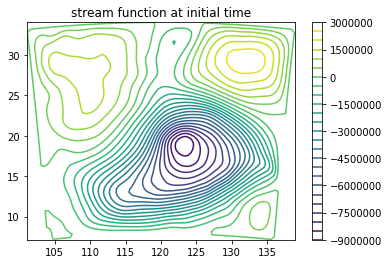

In [8]:
plt.contour(lon[0,:,:], lat[0,:,:], psi, 25)
plt.colorbar()
plt.title('stream function at initial time');

### start to build baratropic model

In [9]:
v = np.zeros((Nt, psi.shape[0], psi.shape[1]))  # time, y, x
u = np.zeros_like(v)
vorticity = np.zeros_like(v)
v.shape

(192, 66, 81)

In [10]:
# initial time
u[0,:,:] = -d_dy(psi, dy)
v[0,:,:] = d_dx(psi, dx)
vorticity[0,:,:] = stfunc_to_vorticity(psi, dx, dy)

# the first time
F = -d_dx(u[0,:,:] * vorticity[0,:,:], dx) - d_dy(v[0,:,:] * vorticity[0,:,:], dy) - beta * v[0,:,:]
vorticity[1,:,:] = vorticity[0,:,:] + dt * F
psi = solve_2D_poisson_fd(81, 66, dx, dy, vorticity[1,1:-1,1:-1])
u[1,:,:] = -d_dy(psi, dy)
v[1,:,:] = d_dx(psi, dx)

# following time
for itime in range(1, Nt-1):
    print(itime)
    F = -d_dx(u[itime,:,:] * vorticity[itime,:,:], dx) - d_dy(v[itime,:,:] * vorticity[itime,:,:], dy) - beta * v[itime,:,:]
    vorticity[itime+1,:,:] = vorticity[itime-1,:,:] + 2 * dt * F
    psi = solve_2D_poisson_fd(81, 66, dx, dy, vorticity[itime+1,1:-1,1:-1])
    u[itime+1,:,:] = -d_dy(psi, dy)
    v[itime+1,:,:] = d_dx(psi, dx)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190


### plot results and save figure

In [12]:
levels = np.linspace(vorticity.min(), vorticity.max(), 12)
for i in range(Nt):
    plt.figure()
    plt.contour(lon[0,:,:], lat[0,:,:], vorticity[i,:,:], levels=levels)
    plt.title(f'{i:03d}')
    plt.colorbar()
    plt.savefig(f'pics/vorticity/{i:03d}.png')
    plt.close()

In [15]:
ws = np.sqrt(u**2 + v**2)
levels = np.arange(0, 17, 1)
for i in range(Nt):
    plt.figure()
    plt.contourf(lon[0,:,:], lat[0,:,:], ws[i,:,:], cmap='rainbow', levels=levels)
    plt.colorbar()
    plt.quiver(lon[0,::3,::3], lat[0,::3,::3], u[i,::3,::3], v[i,::3,::3])
    plt.title(f'{i:03d}')
    plt.savefig(f'pics/wind/{i:03d}.png')
    plt.close()